# Preliminary Multiomic Analysis
The aim here is a preliminary multiomic analysis of the transcriptomic and microbiomic datasets, the aim is to process this all so we can input the data into graphia and plot the clusters found.
This builds on work from
* [ml_transform_rnaseq.ipynb](ml_transform_rnaseq.ipynb)
* [ml_transform_microbiome.ipynb](ml_transform_microbiome.ipynb)

## Libraries and Configs

In [80]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

## Transcriptomic data
Load in the top 1000 variable data (./data/outputs/rnaseq/high_variance_ln_transcript.csv). Then standardise to the sham pigs 1-4 but exclude Pig 4 as it has weird behaviour.

### Load Data

In [23]:
# Load data
high_var_ln_transcriptomic = pd.read_csv("./data/outputs/rnaseq/high_variance_ln_transcript.csv")
#Set the Gene column as the index
high_var_ln_transcriptomic.set_index('gene', inplace=True)
display(high_var_ln_transcriptomic.head())

# Load metadata to identify control (Sham) samples
metadata_df = pd.read_csv("./data/metadata.csv")
metadata_df.rename(columns={'Pig ': 'Pig'}, inplace=True)  # Fix spaces if needed
metadata_df['Pig'] = metadata_df['Pig'].astype(str)
metadata_df['Pig'] = metadata_df['Pig'].apply(lambda x: f'PIG{x}')  # Match RNA-seq names

# Identify control (Sham) sample columns
sham_samples = metadata_df[metadata_df['Treatment'] == "Sham"]['Pig'].tolist()
sham_samples = sham_samples[:3]  # Only use first 3 Sham samples because PIG4 is sick

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
gene,,,,,,,,,,,,
ENSSSCG00000011875,8.502486,8.470521,8.660081,5.926926,8.509766,7.904704,4.442651,2.772589,3.295837,1.098612,5.068904,0.000000
ENSSSCG00000032857,0.000000,0.000000,0.000000,8.017308,2.564949,2.564949,7.260523,5.605802,3.178054,4.290459,2.890372,5.068904
ENSSSCG00000003145,6.647688,3.044522,1.386294,5.342334,3.258097,8.619208,3.332205,2.772589,2.197225,8.330623,8.592857,2.833213
ENSSSCG00000006932,11.010580,10.243632,9.102978,8.759355,10.582561,9.760079,6.431331,6.142037,4.465908,5.010635,4.634729,3.891820
ENSSSCG00000014987,3.295837,3.135494,0.693147,0.693147,5.484797,4.912655,9.408945,7.859799,4.110874,6.731018,5.846439,6.504288


### Z-score

In [30]:
# Compute mean & std of control (Sham) samples per gene
sham_mean = high_var_ln_transcriptomic[sham_samples].mean(axis=1)
sham_std = high_var_ln_transcriptomic[sham_samples].std(axis=1)

# Avoid division by zero by replacing 0 std with a small value (e.g., 1e-6)
sham_std_safe = sham_std.replace(0, 1e-6)

# Compute Z-scores safely (expression relative to Sham)
z_score_df = (high_var_ln_transcriptomic - sham_mean.values.reshape(-1, 1)) / sham_std_safe.values.reshape(-1, 1)
z_score_df = z_score_df.fillna(0)  # Fill NaN values with 0

z_score_df.to_csv("./data/outputs/rnaseq/z_score_ln_transcript_filtered.csv")


### Heatmap for visualisation

In [29]:
# Perform hierarchical clustering on genes (rows)
row_linkage = sch.linkage(dist.pdist(z_score_df, metric="euclidean"), method="ward")
row_dendro = sch.dendrogram(row_linkage, no_plot=True)
row_order = row_dendro['leaves']

# Perform hierarchical clustering on samples (columns)
col_linkage = sch.linkage(dist.pdist(z_score_df.T, metric="euclidean"), method="ward")
col_dendro = sch.dendrogram(col_linkage, no_plot=True)
col_order = col_dendro['leaves']
display(z_score_df.describe())
# Reorder the dataframe based on clustering results
clustered_df = z_score_df.iloc[row_order, :]

# Create an interactive heatmap
fig = px.imshow(
    clustered_df, 
    labels=dict(x="Samples", y="Genes", color="Expression Level"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-9, zmax=9,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Genes",
    width=1000,
    height=800
)

fig.show()

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.082215,-0.255789,0.173575,5.803595e+04,1.477862e+04,3.151399e+04,6.727621e+04,5.615767e+04,4.243832e+04,5.090753e+04,3.596491e+04,5.146409e+04
std,0.777567,0.761821,0.812741,5.291183e+05,2.017104e+05,2.983664e+05,5.142871e+05,4.393616e+05,3.678219e+05,3.873155e+05,3.048615e+05,4.130443e+05
min,-1.154701,-1.154701,-1.154701,-1.018965e+02,-4.192682e+01,-2.979432e+01,-6.934752e+01,-5.687515e+01,-5.171906e+01,-7.337054e+01,-3.424722e+01,-8.419629e+01
25%,-0.577350,-1.024192,-0.577350,-2.341534e+00,-1.034671e+00,-1.261425e+00,-3.095757e+00,-1.763185e+00,-3.224075e+00,-3.038760e+00,-1.903405e+00,-1.760475e+00
50%,0.223966,-0.381356,0.395399,-5.773503e-01,-3.732738e-02,-5.216448e-02,-6.078191e-01,-2.695468e-01,-1.106451e+00,-9.513733e-01,-2.868072e-01,-2.593327e-01
75%,0.764038,0.396351,0.910990,1.356004e+00,7.692382e-01,1.070350e+00,1.159173e+00,1.333364e+00,6.335267e-01,8.894679e-01,1.080921e+00,1.274028e+00
max,1.154701,1.154701,1.154701,8.017308e+06,4.317488e+06,4.043051e+06,7.260523e+06,5.605802e+06,5.093750e+06,4.290459e+06,3.806662e+06,5.068904e+06


### Heatmap no PIG4

In [31]:
remove_PG4 = z_score_df.drop(columns=['PIG4'])
# Perform hierarchical clustering on genes (rows)
row_linkage = sch.linkage(dist.pdist(remove_PG4, metric="euclidean"), method="ward")
row_dendro = sch.dendrogram(row_linkage, no_plot=True)
row_order = row_dendro['leaves']

# Perform hierarchical clustering on samples (columns)
col_linkage = sch.linkage(dist.pdist(remove_PG4.T, metric="euclidean"), method="ward")
col_dendro = sch.dendrogram(col_linkage, no_plot=True)
col_order = col_dendro['leaves']
display(z_score_df.describe())
# Reorder the dataframe based on clustering results
clustered_df = remove_PG4.iloc[row_order, :]

# Create an interactive heatmap
fig = px.imshow(
    clustered_df, 
    labels=dict(x="Samples", y="Genes", color="Expression Level"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-9, zmax=9,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Genes",
    width=1000,
    height=800
)

fig.show()

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.082215,-0.255789,0.173575,5.803595e+04,1.477862e+04,3.151399e+04,6.727621e+04,5.615767e+04,4.243832e+04,5.090753e+04,3.596491e+04,5.146409e+04
std,0.777567,0.761821,0.812741,5.291183e+05,2.017104e+05,2.983664e+05,5.142871e+05,4.393616e+05,3.678219e+05,3.873155e+05,3.048615e+05,4.130443e+05
min,-1.154701,-1.154701,-1.154701,-1.018965e+02,-4.192682e+01,-2.979432e+01,-6.934752e+01,-5.687515e+01,-5.171906e+01,-7.337054e+01,-3.424722e+01,-8.419629e+01
25%,-0.577350,-1.024192,-0.577350,-2.341534e+00,-1.034671e+00,-1.261425e+00,-3.095757e+00,-1.763185e+00,-3.224075e+00,-3.038760e+00,-1.903405e+00,-1.760475e+00
50%,0.223966,-0.381356,0.395399,-5.773503e-01,-3.732738e-02,-5.216448e-02,-6.078191e-01,-2.695468e-01,-1.106451e+00,-9.513733e-01,-2.868072e-01,-2.593327e-01
75%,0.764038,0.396351,0.910990,1.356004e+00,7.692382e-01,1.070350e+00,1.159173e+00,1.333364e+00,6.335267e-01,8.894679e-01,1.080921e+00,1.274028e+00
max,1.154701,1.154701,1.154701,8.017308e+06,4.317488e+06,4.043051e+06,7.260523e+06,5.605802e+06,5.093750e+06,4.290459e+06,3.806662e+06,5.068904e+06


## Load microbiomic data

In [35]:
clr_sham_normalised_df = pd.read_csv("./data/outputs/microbiome/simplified_microbiome_clr_sham_normalised.csv")
clr_sham_normalised_df

,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,5.712125,-12.822773,3.214027,3.896622,-12.485928,-11.985055,1.950571,-7.293887,0.393945,2.563876,-0.498228,2.168895
1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,-12.785886,2.986584,4.314428,5.484874,5.765457,7.508467,6.165398,10.453738,5.349650,6.316346,2.914325,6.519345
2,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,-2.980137,-2.566300,8.441374,-2.894937,-2.229455,-1.728582,10.597607,2.962586,11.033410,-1.492345,-3.370694,9.940467
3,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Aeriscardovia,0.119737,0.533575,-0.858250,0.204938,0.870419,1.371293,0.342435,6.062461,0.183570,1.607530,13.656626,1.041698
4,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,-5.910264,6.958044,4.777283,-5.825063,-5.159582,8.189294,11.864430,0.032460,10.452057,13.610988,10.762118,12.466795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Aggregatibacter,-3.097638,-2.683800,8.793875,-3.012437,-2.346956,-1.846082,-2.874940,2.845086,11.002920,-1.609846,-3.488195,-2.175677
168,Bacteria,Spirochaetes,Spirochaetia,Spirochaetales,Spirochaetaceae,Treponema_2,2.377280,-0.653226,-0.646288,-1.077766,-3.470702,-3.040061,-2.606373,-9.548248,-3.364490,-0.675768,-0.614706,0.630565
169,Bacteria,Tenericutes,Mollicutes,Anaeroplasmatales,Anaeroplasmataceae,Anaeroplasma,-3.167167,10.394287,-4.145154,-3.081966,-2.416485,-1.915611,-2.944469,2.775557,-3.103334,-1.679374,9.165752,-2.245206
170,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,0.119737,0.533575,-0.858250,0.204938,11.580401,1.371293,12.059880,6.062461,12.023077,19.375909,-0.270820,1.041698


## Merging the datasets

### Dropping Pigs 4 and 8

In [37]:
transcript_data_clean = z_score_df.drop(columns=['PIG4','PIG8'])
microbiome_data_clean = clr_sham_normalised_df.drop(columns=['PIG4','PIG8'])

# Save the cleaned data
transcript_data_clean.to_csv("./data/outputs/multiomic/transcript_cleaned.csv")
microbiome_data_clean.to_csv("./data/outputs/multiomic/microbiome_cleaned.csv")

### Data normalisation -1 to 1

In [40]:
def normalise_to_range(data, min_value=-1, max_value=1):
    """
    Normalise each numeric feature in the DataFrame to a specified range [-1, 1].
    Non-numeric columns are left unchanged.
    
    Args:
        data (pd.DataFrame): Input data to normalise.
        min_value (float): Minimum value of the desired range.
        max_value (float): Maximum value of the desired range.
        
    Returns:
        pd.DataFrame: Normalised data.
    """
    normalised_data = data.copy()
    for col in normalised_data.select_dtypes(include=['float', 'int']).columns:
        col_min = normalised_data[col].min()
        col_max = normalised_data[col].max()
        if col_max != col_min:  # Avoid division by zero
            normalised_data[col] = ((normalised_data[col] - col_min) / (col_max - col_min)) * (max_value - min_value) + min_value
        else:
            normalised_data[col] = 0  # If all values are the same, normalize to 0
    return normalised_data

In [43]:
# Normalize the datasets
transcript_data_normalised = normalise_to_range(transcript_data_clean)
microbiome_data_normalised = normalise_to_range(microbiome_data_clean)

# Display the normalised data
display(transcript_data_normalised.describe())
display(microbiome_data_normalised.describe())

# Save the normalized data to CSV files
transcript_data_normalised.to_csv("./data/outputs/multiomic/normalised_transcript_data.csv")
microbiome_data_normalised.to_csv("./data/outputs/multiomic/normalised_microbiome_data.csv")


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.071200,-0.221520,0.150320,-0.993135,-0.984396,-0.981449,-0.983317,-0.976236,-0.981086,-0.979661
std,0.673393,0.659756,0.703854,0.093438,0.147594,0.141665,0.144419,0.180544,0.160171,0.162969
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.500000,-0.886977,-0.500000,-0.999981,-0.999986,-0.999982,-0.999981,-0.999967,-0.999983,-0.999967
50%,0.193960,-0.330264,0.342426,-0.999981,-0.999985,-0.999981,-0.999980,-0.999966,-0.999982,-0.999967
75%,0.661676,0.343250,0.788941,-0.999980,-0.999985,-0.999981,-0.999979,-0.999965,-0.999981,-0.999966
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,0.051018,0.032269,0.076512,0.015140,-0.129676,-0.050237,-0.013437,-0.094395,0.029258,-0.115397
std,0.359369,0.298986,0.300479,0.330788,0.393319,0.460113,0.395763,0.393818,0.407870,0.395986
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.042006,-0.019894,0.006571,-0.136091,-0.275762,-0.261703,-0.198312,-0.225927,-0.137042,-0.258602
50%,0.060860,0.075224,0.015709,0.072174,-0.063243,-0.065132,-0.001484,-0.024594,0.011722,-0.064844
75%,0.125636,0.103821,0.128366,0.091951,-0.011100,0.082866,0.089871,0.022863,0.149273,-0.007994
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Concatentation

In [51]:
# First merge all taxa into a single column for the microbiome data
# Merge Kingdom, Phylum, Class, Order, Family, Genus columns into a single column - seperated by a hyphen
taxa_columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
microbiome_data_normalised['Taxa'] = microbiome_data_normalised[taxa_columns].apply(lambda x: '-'.join(x), axis=1)
# Drop the original columns
microbiome_data_normalised.drop(columns=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'], inplace=True)
# Display the first few rows
display(microbiome_data_normalised.head())

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12,Taxa
0,0.520563,-1.000000,0.338432,-0.802996,-0.847262,0.068786,0.012214,0.050419,-0.003003,0.013667,Archaea-Euryarchaeota-Methanobacteria-Methanob...
1,-1.000000,0.272698,0.428106,0.392920,0.319881,0.325972,0.334900,0.262366,0.217967,0.272547,Archaea-Euryarchaeota-Methanobacteria-Methanob...
2,-0.193954,-0.174325,0.764422,-0.130944,-0.233172,0.596423,0.704993,-0.178686,-0.189002,0.476126,Bacteria-Actinobacteria-Actinobacteria-Actinom...
3,0.060860,0.075224,0.006571,0.072174,-0.047572,-0.029342,-0.001484,-0.003598,0.913556,-0.053409,Bacteria-Actinobacteria-Actinobacteria-Bifidob...
4,-0.434814,0.592412,0.465825,-0.322939,0.360645,0.673724,0.667139,0.674384,0.726130,0.626458,Bacteria-Actinobacteria-Actinobacteria-Bifidob...


In [52]:
#Reorder the columns to but taxa first
cols = list(microbiome_data_normalised.columns)
cols = [cols[-1]] + cols[:-1]
microbiome_data_normalised = microbiome_data_normalised[cols]
display(microbiome_data_normalised.head())

,Taxa,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
0,Archaea-Euryarchaeota-Methanobacteria-Methanob...,0.520563,-1.000000,0.338432,-0.802996,-0.847262,0.068786,0.012214,0.050419,-0.003003,0.013667
1,Archaea-Euryarchaeota-Methanobacteria-Methanob...,-1.000000,0.272698,0.428106,0.392920,0.319881,0.325972,0.334900,0.262366,0.217967,0.272547
2,Bacteria-Actinobacteria-Actinobacteria-Actinom...,-0.193954,-0.174325,0.764422,-0.130944,-0.233172,0.596423,0.704993,-0.178686,-0.189002,0.476126
3,Bacteria-Actinobacteria-Actinobacteria-Bifidob...,0.060860,0.075224,0.006571,0.072174,-0.047572,-0.029342,-0.001484,-0.003598,0.913556,-0.053409
4,Bacteria-Actinobacteria-Actinobacteria-Bifidob...,-0.434814,0.592412,0.465825,-0.322939,0.360645,0.673724,0.667139,0.674384,0.726130,0.626458


In [54]:
# Convert the taxa to the index
microbiome_data_normalised.set_index('Taxa', inplace=True)
display(microbiome_data_normalised.head())

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
Taxa,,,,,,,,,,
Archaea-Euryarchaeota-Methanobacteria-Methanobacteriales-Methanobacteriaceae-Methanobrevibacter,0.520563,-1.000000,0.338432,-0.802996,-0.847262,0.068786,0.012214,0.050419,-0.003003,0.013667
Archaea-Euryarchaeota-Methanobacteria-Methanobacteriales-Methanobacteriaceae-Methanosphaera,-1.000000,0.272698,0.428106,0.392920,0.319881,0.325972,0.334900,0.262366,0.217967,0.272547
Bacteria-Actinobacteria-Actinobacteria-Actinomycetales-Actinomycetaceae-Actinomyces,-0.193954,-0.174325,0.764422,-0.130944,-0.233172,0.596423,0.704993,-0.178686,-0.189002,0.476126
Bacteria-Actinobacteria-Actinobacteria-Bifidobacteriales-Bifidobacteriaceae-Aeriscardovia,0.060860,0.075224,0.006571,0.072174,-0.047572,-0.029342,-0.001484,-0.003598,0.913556,-0.053409
Bacteria-Actinobacteria-Actinobacteria-Bifidobacteriales-Bifidobacteriaceae-Bifidobacterium,-0.434814,0.592412,0.465825,-0.322939,0.360645,0.673724,0.667139,0.674384,0.726130,0.626458


In [58]:
# Merge the transcriptomic and microbiome data
combined_data = pd.concat([transcript_data_normalised, microbiome_data_normalised], axis=0)
# Display the first few rows
display(combined_data.head())
display(combined_data.tail())
display(combined_data.describe())

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
ENSSSCG00000011875,-3.573693e-01,-6.301512e-01,0.987520,-0.999981,-0.999988,-0.999992,-1.000000,-1.000000,-1.000000,-1.000000
ENSSSCG00000032857,-2.220446e-16,2.220446e-16,0.000000,0.188175,0.268824,1.000000,0.247832,1.000000,0.518590,1.000000
ENSSSCG00000003145,9.513128e-01,-2.087238e-01,-0.742589,-0.999981,-0.999984,-0.999981,-0.999980,-0.999965,-0.999981,-0.999967
ENSSSCG00000006932,8.043446e-01,1.123880e-01,-0.916733,-0.999980,-0.999985,-0.999982,-0.999982,-0.999968,-0.999985,-0.999969
ENSSSCG00000014987,5.468454e-01,4.516428e-01,-0.998488,-0.999980,-0.999984,-0.999980,-0.999979,-0.999964,-0.999981,-0.999966


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
Bacteria-Proteobacteria-Gammaproteobacteria-Pasteurellales-Pasteurellaceae-Aggregatibacter,-0.203612,-0.183784,0.793148,-0.138643,-0.240207,-0.225664,0.703008,-0.185323,-0.196610,-0.244864
Bacteria-Spirochaetes-Spirochaetia-Spirochaetales-Spirochaetaceae-Treponema_2,0.246434,-0.020317,0.023844,-0.212276,-0.311695,-0.209276,-0.232513,-0.132564,-0.010546,-0.077874
Bacteria-Tenericutes-Mollicutes-Anaeroplasmatales-Anaeroplasmataceae-Anaeroplasma,-0.209328,0.869039,-0.261287,-0.143199,-0.244370,-0.229907,-0.215508,-0.189250,0.622761,-0.249001
Bacteria-Verrucomicrobia-Verrucomicrobiae-Verrucomicrobiales-Akkermansiaceae-Akkermansia,0.060860,0.075224,0.006571,0.773942,-0.047572,0.685650,0.769434,1.000000,0.011722,-0.053409
Eukaryota-Parabasalia-Trichomonadea-Trichomonadea_or-Trichomonadea_fa-Tetratrichomonas,0.060860,0.075224,0.006571,0.072174,0.760834,-0.029342,-0.001484,-0.003598,0.011722,-0.053409


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
count,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000
mean,0.068238,-0.184275,0.139488,-0.845163,-0.858959,-0.844786,-0.840980,-0.846819,-0.832811,-0.852824
std,0.636995,0.626474,0.660689,0.388377,0.364324,0.395871,0.398192,0.384598,0.417268,0.373054
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.500000,-0.818310,-0.426406,-0.999981,-0.999986,-0.999982,-0.999981,-0.999967,-0.999983,-0.999967
50%,0.095984,-0.168131,0.168487,-0.999980,-0.999985,-0.999981,-0.999980,-0.999966,-0.999982,-0.999967
75%,0.614561,0.306691,0.734669,-0.999980,-0.999984,-0.999980,-0.999979,-0.999964,-0.999981,-0.999966
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Yes all looks good. Let's go ahead and save this csv

In [59]:
combined_data.to_csv("./data/outputs/multiomic/combined_data.csv")

### Weightings
Weightings are needed to handle the data size imbalance between the transcripts (n=1000), and the microbiome (n=172)

In [66]:
# Calculate the weighting factor for each omic
gene_features = combined_data[combined_data.index.str.startswith('ENSSSCG')]
microbiome_features = combined_data[~combined_data.index.str.startswith('ENSSSCG')]

n_genes = gene_features.shape[0]
n_microbiome = microbiome_features.shape[0]
direct_ratio_weight_factor = n_microbiome / n_genes #Not using this for now, but if microbiome is still underrepresented, we can use this to weight the microbiome data
proportional_ratio_weight_factor = n_microbiome / (n_microbiome + n_genes)
scale_factor = 1 / proportional_ratio_weight_factor

print(f"Proportional ratio weight factor: {proportional_ratio_weight_factor:.2f}")
print(f"Scale_factor: {scale_factor:.2f}")

# Scale the microbiome data
weighted_microbiome_features = microbiome_features * scale_factor

# Concatenate again
weighted_combined_data = pd.concat([gene_features, weighted_microbiome_features], axis=0)
display(weighted_combined_data.head())
display(weighted_combined_data.tail())

Proportional ratio weight factor: 0.15
Scale_factor: 6.81


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
ENSSSCG00000011875,-3.573693e-01,-6.301512e-01,0.987520,-0.999981,-0.999988,-0.999992,-1.000000,-1.000000,-1.000000,-1.000000
ENSSSCG00000032857,-2.220446e-16,2.220446e-16,0.000000,0.188175,0.268824,1.000000,0.247832,1.000000,0.518590,1.000000
ENSSSCG00000003145,9.513128e-01,-2.087238e-01,-0.742589,-0.999981,-0.999984,-0.999981,-0.999980,-0.999965,-0.999981,-0.999967
ENSSSCG00000006932,8.043446e-01,1.123880e-01,-0.916733,-0.999980,-0.999985,-0.999982,-0.999982,-0.999968,-0.999985,-0.999969
ENSSSCG00000014987,5.468454e-01,4.516428e-01,-0.998488,-0.999980,-0.999984,-0.999980,-0.999979,-0.999964,-0.999981,-0.999966


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
Bacteria-Proteobacteria-Gammaproteobacteria-Pasteurellales-Pasteurellaceae-Aggregatibacter,-1.387405,-1.252296,5.404474,-0.944707,-1.636762,-1.537665,4.790262,-1.262780,-1.339695,-1.668489
Bacteria-Spirochaetes-Spirochaetia-Spirochaetales-Spirochaetaceae-Treponema_2,1.679187,-0.138440,0.162475,-1.446439,-2.123875,-1.426000,-1.584330,-0.903284,-0.071857,-0.530630
Bacteria-Tenericutes-Mollicutes-Anaeroplasmatales-Anaeroplasmataceae-Anaeroplasma,-1.426349,5.921591,-1.780399,-0.975750,-1.665128,-1.566574,-1.468459,-1.289540,4.243467,-1.696682
Bacteria-Verrucomicrobia-Verrucomicrobiae-Verrucomicrobiales-Akkermansiaceae-Akkermansia,0.414700,0.512571,0.044776,5.273606,-0.324155,4.671989,5.242889,6.813953,0.079872,-0.363926
Eukaryota-Parabasalia-Trichomonadea-Trichomonadea_or-Trichomonadea_fa-Tetratrichomonas,0.414700,0.512571,0.044776,0.491793,5.184289,-0.199933,-0.010112,-0.024517,0.079872,-0.363926


Looks good to me. Now save as csv

In [67]:
weighted_combined_data.to_csv("./data/outputs/multiomic/weighted_combined_data.csv")

## EDA on weighted dataset

### Distribution Plot of Weighted Data

In [72]:
weighted_combined_data = pd.read_csv("./data/outputs/multiomic/weighted_combined_data.csv", index_col=0)
display(weighted_combined_data.head())
display(weighted_combined_data.tail())

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
ENSSSCG00000011875,-3.573693e-01,-6.301512e-01,0.987520,-0.999981,-0.999988,-0.999992,-1.000000,-1.000000,-1.000000,-1.000000
ENSSSCG00000032857,-2.220446e-16,2.220446e-16,0.000000,0.188175,0.268824,1.000000,0.247832,1.000000,0.518590,1.000000
ENSSSCG00000003145,9.513128e-01,-2.087238e-01,-0.742589,-0.999981,-0.999984,-0.999981,-0.999980,-0.999965,-0.999981,-0.999967
ENSSSCG00000006932,8.043446e-01,1.123880e-01,-0.916733,-0.999980,-0.999985,-0.999982,-0.999982,-0.999968,-0.999985,-0.999969
ENSSSCG00000014987,5.468454e-01,4.516428e-01,-0.998488,-0.999980,-0.999984,-0.999980,-0.999979,-0.999964,-0.999981,-0.999966


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
Bacteria-Proteobacteria-Gammaproteobacteria-Pasteurellales-Pasteurellaceae-Aggregatibacter,-1.387405,-1.252296,5.404474,-0.944707,-1.636762,-1.537665,4.790262,-1.262780,-1.339695,-1.668489
Bacteria-Spirochaetes-Spirochaetia-Spirochaetales-Spirochaetaceae-Treponema_2,1.679187,-0.138440,0.162475,-1.446439,-2.123875,-1.426000,-1.584330,-0.903284,-0.071857,-0.530630
Bacteria-Tenericutes-Mollicutes-Anaeroplasmatales-Anaeroplasmataceae-Anaeroplasma,-1.426349,5.921591,-1.780399,-0.975750,-1.665128,-1.566574,-1.468459,-1.289540,4.243467,-1.696682
Bacteria-Verrucomicrobia-Verrucomicrobiae-Verrucomicrobiales-Akkermansiaceae-Akkermansia,0.414700,0.512571,0.044776,5.273606,-0.324155,4.671989,5.242889,6.813953,0.079872,-0.363926
Eukaryota-Parabasalia-Trichomonadea-Trichomonadea_or-Trichomonadea_fa-Tetratrichomonas,0.414700,0.512571,0.044776,0.491793,5.184289,-0.199933,-0.010112,-0.024517,0.079872,-0.363926


In [75]:
# Flatten the data to plot distribution
flattened_values = weighted_combined_data.values.flatten()

# Create a histogram to visualize the distribution
fig = px.histogram(flattened_values, nbins=50, title="Distribution of Weighted Data")
fig.update_layout(xaxis_title="Value", yaxis_title="Frequency")
fig.show()
fig.write_html("./data/outputs/multiomic/weighted_data_distribution.html")

Interesting, the majority of data seems down regulated (around -1). Is this because of the adding of a small factor in the log transforms?

In [78]:
# Flatten the data to plot distribution
combined_flattened_values = combined_data.values.flatten()

# Create a histogram to visualize the distribution
fig = px.histogram(combined_flattened_values, nbins=50, title="Distribution of Weighted Data")
fig.update_layout(xaxis_title="Value", yaxis_title="Frequency")
fig.show()
fig.write_html("./data/outputs/multiomic/combined_data_distribution.html")

Yup it's just because of the adding of a small value for log transforms. Let's ignore it for now

### Correlation heat maps

In [83]:
# Calculate the correlation matrix
correlation_matrix = weighted_combined_data.corr()

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='Magma',
    colorbar_title="Correlation"
))

fig.update_layout(
    title="Correlation Heatmap of Corrected Normalised Data",
    xaxis_title="Sample",
    yaxis_title="Sample"
)

# Show the plot
fig.show()
fig.write_html("./data/outputs/multiomic/correlation_heatmap.html")

Hmm. This anti correlation in the control could be a problem. Maybe the transcriptomic data is more noisy than I realised. Perhaps in the 1000 most variable. It should be the 1,000 most variable excluding the control? Too late for now so let's continue

### PCA

cumulative_variance: [ 33.44462443  49.51106149  63.25629318  71.71033656  79.37314832
  85.90986538  91.28972949  96.16726224 100.         100.        ]


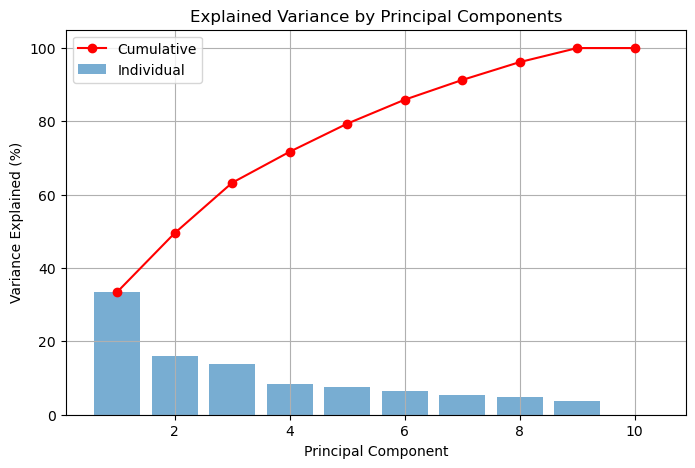

<Figure size 640x480 with 0 Axes>

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA on the Z-score matrix
pca = PCA()
pca.fit(weighted_combined_data.T)  # Transpose so samples are rows

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage
cumulative_variance = np.cumsum(explained_variance)  # Cumulative sum
print(f"cumulative_variance: {cumulative_variance}")

# Plot explained variance
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label="Individual")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r', label="Cumulative")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.grid()
plt.show()
plt.savefig("./data/outputs/multiomic/explained_variance_pca.png")


I think 2d is sufficient for now

In [88]:
metadata_df

,Pig,Treatment,Day Euthanized,Max Fecal Score
0,PIG1,Sham,21,0
1,PIG2,Sham,21,0
2,PIG3,Sham,21,0
3,PIG4,Sham,21,0
4,PIG5,Bhyo,21,2
5,PIG6,Bhyo,14,4
6,PIG7,Bhyo,11,4
7,PIG8,Bhyo,18,4
8,PIG9,Bhamp,21,1
9,PIG10,Bhamp,21,1


In [90]:
# Transpose data so that samples are rows and features are columns
data_transposed = weighted_combined_data.T

# Perform PCA (2 components)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_transposed)

# Merge PCA results with metadata for labeling
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=data_transposed.index)
pca_df = pca_df.merge(metadata_df[['Pig', 'Treatment']], left_index=True, right_on='Pig')

# Plotting PCA scatter plot with group coloring
fig = px.scatter(
    pca_df, x="PC1", y="PC2", color="Treatment", text="Pig",
    title=f"PCA (2D) of Weighted Combined Data: PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%) vs PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)",
    labels={"PC1": "PC1", "PC2": "PC2"},
    template="plotly_white"
)
fig.update_traces(textposition='top center')
fig.show()
fig.write_html("./data/outputs/multiomic/pca_2d.html")

The sham group’s wider spread likely reflects the inherent variability in the chosen gene set. This isn’t unexpected given that the most variable genes were selected, which naturally captures more variance. There are some extreme values here.

### Hierarchical clustering

In [93]:
# Perform hierarchical clustering on genes (rows)
row_linkage = sch.linkage(dist.pdist(weighted_combined_data, metric="euclidean"), method="ward")
row_dendro = sch.dendrogram(row_linkage, no_plot=True)
row_order = row_dendro['leaves']

# Perform hierarchical clustering on samples (columns)
col_linkage = sch.linkage(dist.pdist(weighted_combined_data.T, metric="euclidean"), method="ward")
col_dendro = sch.dendrogram(col_linkage, no_plot=True)
col_order = col_dendro['leaves']
display(weighted_combined_data.describe())
# Reorder the dataframe based on clustering results
clustered_df = weighted_combined_data.iloc[row_order, :]

# Create an interactive heatmap
fig = px.imshow(
    clustered_df, 
    labels=dict(x="Samples", y="Genes", color="Expression Level"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-7, zmax=7,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Genes",
    width=1000,
    height=800
)

fig.show()
fig.write_html("./data/outputs/multiomic/clustered_multiomic_heatmap.html")

# fig.write_html("./data/outputs/rnaseq/heatmap_plotly.html")
# print("Heatmap saved as HTML!")

# # Save the clustered dataframe
# z_score_df.to_csv("./data/outputs/rnaseq/z_score_df.csv", index=True)

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
count,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000
mean,0.111769,-0.156741,0.204772,-0.832244,-0.969605,-0.887651,-0.852445,-0.927361,-0.807846,-0.951285
std,1.127854,1.000926,1.025699,0.948663,1.033799,1.226252,1.086010,1.045589,1.150849,1.044270
min,-6.813953,-6.813953,-6.813953,-6.813953,-6.813953,-6.813953,-6.813953,-6.813953,-6.813953,-6.813953
25%,-0.500000,-0.882447,-0.500000,-0.999981,-0.999986,-0.999982,-0.999981,-0.999967,-0.999983,-0.999968
50%,0.251202,-0.181093,0.298008,-0.999981,-0.999985,-0.999981,-0.999980,-0.999966,-0.999982,-0.999967
75%,0.669913,0.493032,0.790880,-0.999980,-0.999985,-0.999980,-0.999979,-0.999965,-0.999981,-0.999966
max,6.813953,6.813953,6.813953,6.813953,6.813953,6.813953,6.813953,6.813953,6.813953,6.813953


## Remove low variance nodes

In [100]:
# Load the weighted combined data
weighted_data = pd.read_csv("./data/outputs/multiomic/weighted_combined_data.csv", index_col=0)

# Calculate variance for each feature
variances = weighted_data.var(axis=1)

# Create a histogram to visualize the distribution
fig = px.histogram(variances, nbins=100, title="Distribution of Variances")
fig.update_layout(xaxis_title="Value", yaxis_title="Frequency")
fig.show()
fig.write_html("./data/outputs/multiomic/variance_distribution.html")

In [102]:
# Set a variance threshold
variance_threshold = 0.5

# Filter out low-variance features
filtered_data = weighted_data[variances > variance_threshold]

# Save the filtered data to a new CSV file
filtered_data.to_csv("./data/outputs/multiomic/filtered_weighted_combined_data.csv")
print(f"Filtered data saved with {filtered_data.shape[0]} features remaining.")

Filtered data saved with 139 features remaining.


In [103]:
filtered_data

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
ENSSSCG00000059419,-2.220446e-16,2.220446e-16,0.000000,-0.999981,-0.999985,-0.999981,-0.999980,0.292456,0.938118,0.519132
Archaea-Euryarchaeota-Methanobacteria-Methanobacteriales-Methanobacteriaceae-Methanobrevibacter,3.547089e+00,-6.813953e+00,2.306057,-5.471575,-5.773206,0.468703,0.083228,0.343550,-0.020464,0.093124
Archaea-Euryarchaeota-Methanobacteria-Methanobacteriales-Methanobacteriaceae-Methanosphaera,-6.813953e+00,1.858151e+00,2.917096,2.677339,2.179657,2.221160,2.281995,1.787753,1.485219,1.857120
Bacteria-Actinobacteria-Actinobacteria-Actinomycetales-Actinomycetaceae-Actinomyces,-1.321591e+00,-1.187842e+00,5.208734,-0.892245,-1.588825,4.064000,4.803789,-1.217558,-1.287851,3.244298
Bacteria-Actinobacteria-Actinobacteria-Bifidobacteriales-Bifidobacteriaceae-Aeriscardovia,4.147002e-01,5.125709e-01,0.044776,0.491793,-0.324155,-0.199933,-0.010112,-0.024517,6.224926,-0.363926
...,...,...,...,...,...,...,...,...,...,...
Bacteria-Proteobacteria-Gammaproteobacteria-Pasteurellales-Pasteurellaceae-Aggregatibacter,-1.387405e+00,-1.252296e+00,5.404474,-0.944707,-1.636762,-1.537665,4.790262,-1.262780,-1.339695,-1.668489
Bacteria-Spirochaetes-Spirochaetia-Spirochaetales-Spirochaetaceae-Treponema_2,1.679187e+00,-1.384399e-01,0.162475,-1.446439,-2.123875,-1.426000,-1.584330,-0.903284,-0.071857,-0.530630
Bacteria-Tenericutes-Mollicutes-Anaeroplasmatales-Anaeroplasmataceae-Anaeroplasma,-1.426349e+00,5.921591e+00,-1.780399,-0.975750,-1.665128,-1.566574,-1.468459,-1.289540,4.243467,-1.696682
Bacteria-Verrucomicrobia-Verrucomicrobiae-Verrucomicrobiales-Akkermansiaceae-Akkermansia,4.147002e-01,5.125709e-01,0.044776,5.273606,-0.324155,4.671989,5.242889,6.813953,0.079872,-0.363926
